# Basic pathpyG Concepts

## Prerequisites

First, we need to set up our Python environment that has PyTorch, PyTorch Geometric and PathpyG installed. Depending on where you are executing this notebook, this might already be (partially) done. E.g. Google Colab has PyTorch installed by default so we only need to install the remaining dependencies. The DevContainer that is part of our GitHub Repository on the other hand already has all of the necessary dependencies installed. 

In the following, we install the packages for usage in Google Colab using Jupyter magic commands. For other environments comment in or out the commands as necessary. For more details on how to install `pathpyG` especially if you want to install it with GPU-support, we refer to our [documentation](https://www.pathpy.net/dev/getting_started/). Note that `%%capture` discards the full output of the cell to not clutter this tutorial with unnecessary installation details. If you want to print the output, you can comment `%%capture` out.

In [1]:
%%capture
# !pip install torch
!pip install torch_geometric
!pip install git+https://github.com/pathpy/pathpyG.git

## Motivation and Learning Objectives

This first step of our multi-stage introductory tutorial introduces key concepts of `pathpyG`. While `pathpyG` targets GPU-accelerated analysis and learning using higher-order graph models for time series data on graphs, it can also be used to represent, analyze and interactively visualize static graphs. For this, it provides a `Graph` class that is build around the `torch_geometric.data.Data` object, which has the advantage that we can directly apply `pyG` transforms and use the `Graph` object for deep graph learning.

In this tutorial you will learn how we can use `pathpyG` to represent static graphs. We start with basic features to create directed and undirected graphs with node-, edge-, and graph-level attributes. We also show how we can read and write graph data and how we can implement graph algorithms that are based on a traversal of nodes and edges.

We first import the modules `torch`, `torch_geometric` and `pathpyG`.

In [1]:
import torch
import torch_geometric as pyG
from torch_geometric.data import Data
import pandas as pd

import pathpyG as pp

## Creating Graph objects
 
Let's start by generating a simple, directed graph with three nodes `a`, `b`, `c` and three edges `(a,b)`, `(b,c)` and `(a,b)`. The three nodes `a`, `b`, and `c` can be represented by integer indices $0, 1$ and $2$ respectively. Following the tensor-based representation in `pyG`, we use an `edge_index` tensor with shape `(2,m)` to represent the `m` edges of a graph.
We can then add this to a `Data` object that can hold additional node and edge attributes. We finally pass the `Data` object to the constructor of the `Graph` class.

Using the mapping of node names to indices specified above, the following code generates a directed `Graph` with three edges `(a,c)`, `(b,c)` and `(a,b)`.

In [2]:
d = Data(edge_index = torch.tensor([[0,1,0], [2,2,1]]))
g = pp.Graph(d)
print(g)

Directed graph with 3 nodes and 3 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


If we do not need additional node or edge attributes, we can use the class function `Graph.from_edge_index` to directly create a graph based on an edge index:

In [3]:
g = pp.Graph.from_edge_index(torch.tensor([[0,1,0], [2,2,1]]))
print(g)

Directed graph with 3 nodes and 3 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


We may want to inlude isolated nodes that do not have an edge. We can do so by passing a `num_nodes` parameter. The following graph thus contains a fourth node (which we could name as `d`) that is not connected to any of the other nodes.

In [4]:
g = pp.Graph.from_edge_index(torch.tensor([[0,1,0], [2,2,1]]), num_nodes=4)
print(g)

Directed graph with 4 nodes and 3 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


In both cases, the `Graph` instance has a property `g.data` that stores a `pyG` `Data` object that includes the edge index as well as any further node-, edge- or graph-level attributes.

In [5]:
print(g.data)

Data(edge_index=[2, 3], num_nodes=4, node_sequence=[4, 1])


Note that the `edge_index` is actually of type `pyG.EdgeIndex`, which is a subclass of `torch.Tensor`. Any tensor passed as an edge index in the constructor of `Graph` will automatically be converted to an `EdgeIndex` instance, as this internally allows us to provide efficient edge traveral routines based on sparse matrix operations. To support this, the edge index will be automatically sorted by row when the `Graph` object is created. To avoid this additional sort operation, you can pass an already sorted `EdgeIndex` object in the `Data` object in the constructor or using the `from_edge_index` class function.

In [6]:
print(g.data.edge_index)

EdgeIndex([[0, 0, 1],
           [2, 1, 2]], sparse_size=(4, 4), nnz=3, sort_order=row)


We can use the generators `nodes` and `edges` to iterate through the nodes and edges of a graph as follows:

In [7]:
for v in g.nodes:
    print(v)

for e in g.edges:
    print(e)

0
1
2
3
(0, 2)
(0, 1)
(1, 2)


While the index-based representation of nodes allows for efficient tensor-based operations, it is often more convenient to use string identifiers to refer to nodes. To simplify the handling of graphs with such string node identifiers, `pathpyG` provides a class `IndexMap` that transparently maps string identifiers to integer indices. For our small example graph, we can create an `IndexMap` that associates node indices with string IDs. For our example, we can create a mapping as follows:

In [8]:
m = pp.IndexMap(['a', 'b', 'c', 'd'])
print(m)

a -> 0
b -> 1
c -> 2
d -> 3



We can use the functions `IndexMap.to_id` or `IndexMap.to_idx` to map a node to an index or an ID:

In [9]:
m.to_id(0)

np.str_('a')

In [10]:
m.to_idx('b')

1

`pathpyG` actually makes this mapping transparent for the user. For this, we can add our mapping to the `Graph` object, either by passing it in the constructor or by setting the `mapping` attribute of an existing `Graph` instance.

In [11]:
g.mapping = m

If we now iterate through the nodes and edges of the graph, we get:

In [12]:
for v in g.nodes:
    print(v)

for e in g.edges:
    print(e)

a
b
c
d
('a', 'c')
('a', 'b')
('b', 'c')


We can achieve the same result if we pass the `IndexMap` object in the constructor of a graph. This transparently applies the mapping in all future function calls.

In [13]:
g = pp.Graph.from_edge_index(torch.tensor([[0,1,0], [2,2,1]]), num_nodes = 4, mapping=m)
print(g)

Directed graph with 4 nodes and 3 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


Above, we have created a graph based on an edge index tensor and we then additionally applied a mapping that we manually defined. We often have data in the form on an edge list, where edges are given as tuples of non-numeric node identifiers. The class function `Graph.from_edge_list` simplifies the construction of a `Graph` from such edge lists. This will automatically generate an internal integer-based representation of the edge index, as well as the associated `IndexMap`, where the integer node indices are based on the lexicographic order of node IDs.

In [14]:
g = pp.Graph.from_edge_list([('a','b'), ('b','c'), ('a','c')])
print(g)
print(g.data.edge_index)
print(g.mapping)

Directed graph with 3 nodes and 3 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}
EdgeIndex([[0, 0, 1],
           [1, 2, 2]], sparse_size=(3, 3), nnz=3, sort_order=row)
a -> 0
b -> 1
c -> 2



We could alternatively pass a custom index mapping, e.g. mapping node `c` to idex 1 and node `b` to index 2 (thus deviating from a lexicographic order):

In [15]:
g = pp.Graph.from_edge_list([('a','b'), ('a','c'), ('b','c')], mapping = pp.IndexMap(['a', 'c', 'b']))
print(g.data.edge_index)
print(g.mapping)

EdgeIndex([[0, 0, 2],
           [2, 1, 1]], sparse_size=(3, 3), nnz=3, sort_order=row)
a -> 0
c -> 1
b -> 2



## Traversing Graphs


The `Graph` object provides `get_successors` and `get_predecessors` functions, which return the indices of nodes that are connected to a node with a given index. Based on cached CSR (compressed sparse row) and CSC (compressed sparse column) representations cached for the sorted `EdgeIndex`, access to the successors and predecessors of a node works in constant time, i.e. it does not require to enumerate the `edge_index` tensor.


For node `a` with index $0$ in our directed network we obtain:

In [16]:
g.get_successors(0)

tensor([2, 1])

In [17]:
g.get_predecessors(0)

tensor([], dtype=torch.int64)

Note that, even if a mapping is defined, the `get_successors` and `get_predecessors` functions always return a tensor with node indices, rather than node IDs. This is useful to support fast tensor-based operations on the list of successors and predecessors. We could always manually map the node indices using the `IndexMap` object defined in the `mapping` attribute.

If we want to traverse graphs based on string node IDs, we can use the `successors` and `predecessors` generators of the `Graph` object, which -- if an ID-Index mapping is defined - yield the string labels of successor or predecessor nodes for a given node (also identified by its string label).

In [18]:
for v in g.successors('a'):
    print(v)

b
c


In [19]:
for v in g.predecessors('c'):
    print(v)

a
b


To check (again in constant time) whether an edge exists in the graph, we can call the `is_edge` function:

In [20]:
g.is_edge('a', 'b')

True

Alternatively, we can use the following function to check (in constant time) whether node `b` is a successor of `a`

In [21]:
'b' in g.successors('a')

True

By default, graph objects in `pathpyG` are directed, i.e. for the graph above, the edge `(b,a)` does not exist, which we can verify as follows:

In [22]:
print('a' in g.successors('b'))
print(g.is_edge('b', 'a'))

False
False


To calculate (directed) in- and out-degrees of nodes, we can use the properties `in_degrees` and `out_degrees`, which return a dictionary that maps node IDs to their degrees:

In [23]:
g.in_degrees

{np.str_('a'): 0, np.str_('c'): 2, np.str_('b'): 1}

In [24]:
g.in_degrees['b']

1

In [25]:
g.in_degrees['a']

0

In [26]:
g.in_degrees['c']

2

Importantly, irrespective of how we have generated the graph object, the actual node and edge data are always stored as a `pyG` data object. This allows us to use the full power of `torch` and `pyG`, including the application of transforms, splits, or any easy migration between CPU and GPU-based computation. 

In [27]:
g.data

Data(edge_index=[2, 3], num_nodes=3, node_sequence=[3, 1])

In general, `pathpyG` handles device placement (i.e. if a tensor should be placed on CPU or GPU memory) similar to `pytorch`. By default, all tensors are created on the CPU, as we can see below:

In [28]:
g.data.is_cuda

False

If we instead want to create a graph on the GPU, we can specify the device during graph creation.

In [29]:
g = pp.Graph.from_edge_list([('a','b'), ('b','c'), ('a','c')], device='cuda')
g.data.is_cuda

True

We can move a graph that is stored on the GPU back to the CPU using the familiar `to` function:

In [30]:
g = g.to('cpu')

## Node-, Edge- or Graph-Level Attributes

Real-world graphs often have node-, edge-, or graph-level attributes. In `pathpyG`, we can add attributes as tensors, either by directly assigning them to the `pyG` data object of an existing graph (or by adding them to the `Data` object passed to the constructor). Following the `pyG` semantics of attribute names, we use the prefixes `node_` and `edge_` to refer to node- and edge-level attributes. Attributes without those prefixes are assumed to refer to graph-level attributes.

In [34]:
g.data['node_class'] = torch.tensor([[0], [0], [1]])
g.data['edge_weight'] = torch.tensor([[1], [2], [3]])
g.data['feature'] = torch.tensor([3, 2])

Once we have added attributes to nodes, edges, or the graph, those attributes, along with their type and shape will be shown when you print a string representation of the graph object:

In [35]:
print(g)

Directed graph with 3 nodes and 3 edges
{   'Edge Attributes': {'edge_weight': "<class 'torch.Tensor'> -> torch.Size([3, 1])"},
    'Graph Attributes': {'feature': "<class 'torch.Tensor'> -> torch.Size([2])", 'num_nodes': "<class 'int'>"},
    'Node Attributes': {'node_class': "<class 'torch.Tensor'> -> torch.Size([3, 1])"}}


To simplify access to attribute values, the `Graph` class provides getter and setter functions that allow to access attribute values based on node identifiers. To access the feature `node_feature` of node `a`, we can write:

In [36]:
g['node_class', 'a']

tensor([0])

To access the weight of edge `(a, b)` we can write:

In [37]:
g['edge_weight', 'a', 'b']

tensor([1])

And finally, graph-based attributes can accessed as follows:

In [38]:
g['feature']

tensor([3, 2])

We can also use the setter functions to change attributes:

In [39]:
g['node_class'] = torch.tensor([[7], [2], [3]], device='cuda')

In [40]:
g['node_class', 'a']

tensor([7], device='cuda:0')

To create sparse adjacency matrix representations of graphs, we can use the following function:

In [41]:
print(g.sparse_adj_matrix())

<COOrdinate sparse matrix of dtype 'float32'
	with 3 stored elements and shape (3, 3)>
  Coords	Values
  (0, 1)	1.0
  (0, 2)	1.0
  (1, 2)	1.0


This returns a `scipy.sparse.coo_matrix` object, which can be turned into a dense `numpy` matrix as follows: 

In [42]:
print(g.sparse_adj_matrix().todense())

[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]


By passing the name of the attribute, we can use edge attributes in the creation of the adjacency matrix. To create a sparse, weighted adjacency matrix that uses the `edge_weight` attribute of our graph object we can simply write:

In [43]:
print(g.sparse_adj_matrix(edge_attr='edge_weight').todense())

[[0 1 2]
 [0 0 3]
 [0 0 0]]


By default, graphs in `pathpyG` are directed. To represent undirected edges, we must add edges in both directions. We can use the `to_undirected()` function to make a directed graph undirected, which adds all (missing) edges that point in the opposite direction. This will also automatically duplicate and assign the corresponding edge attributes to the newly formed (directed) edges, i.e. edges are assumed to have the same attributes in both directions.

In [44]:
g_u = g.to_undirected()
print(g_u)

Undirected graph with 3 nodes and 6 (directed) edges
{   'Edge Attributes': {'edge_weight': "<class 'torch.Tensor'> -> torch.Size([6, 1])"},
    'Graph Attributes': {'num_nodes': "<class 'int'>"},
    'Node Attributes': {'node_class': "<class 'torch.Tensor'> -> torch.Size([3, 1])"}}


By default, the `Graph` object can contain multiple identical edges, so the following is possible: 

In [45]:
g = pp.Graph.from_edge_list([('a', 'b'), ('b', 'c'), ('c', 'a'), ('a', 'b')])
print(g.data.edge_index)

EdgeIndex([[0, 0, 1, 2],
           [1, 1, 2, 0]], sparse_size=(3, 3), nnz=4, sort_order=row)


It is often convenient, to coalesce multi-edges into weighted single-edges, i.e. in the example above we may prefer a graph where each edge occurs once in the edge index, but the edge `a->b` has a weight attribute of two, while the two other edges have one.

In `pathpyG` we can do this by turning a graph into a weighted graph, which will coalesce edges and add an edge weight attribute that counts multi-edges in the original istance.

In [46]:
g_w = g.to_weighted_graph()
print(g_w.data.edge_index)
print(g_w['edge_weight', 'a', 'b'])
print(g_w['edge_weight', 'b', 'c'])
print(g_w['edge_weight', 'c', 'a'])

EdgeIndex([[0, 1, 2],
           [1, 2, 0]], sparse_size=(3, 3), nnz=3, sort_order=row)
tensor(2.)
tensor(1.)
tensor(1.)


As we will see in a separate notebook focusing on the advanced (temporal) graph visualization features of `pathpyG`, it is easy to generate (interactive) HTML plots of graphs, that are embedded into jupyter notebooks. You can simply call the `pp.plot` function on the Graph object:

In [47]:
pp.plot(g, edge_color='gray', node_label=g.mapping.node_ids.tolist());

## Reading and writing graph data

In [48]:
g = pp.Graph.from_edge_list([('a','b'), ('b','c'), ('c','a')])
print(g)

df = pp.io.graph_to_df(g)
print(df)

Directed graph with 3 nodes and 3 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}
   v  w
0  a  b
1  b  c
2  c  a


In [50]:
g.data.edge_weight = torch.tensor([1.0, 2.0, 3.0])
print(g)

df = pp.io.graph_to_df(g)
print(df)

Directed graph with 3 nodes and 3 edges
{'Edge Attributes': {'edge_weight': "<class 'torch.Tensor'> -> torch.Size([3])"}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}
   v  w  edge_weight
0  a  b          1.0
1  b  c          2.0
2  c  a          3.0


In [51]:
node_attr = pd.DataFrame({'v': ['b', 'a', 'c'], 'node_size': [5.0, 2.0, 1.0]})
print(node_attr)

   v  node_size
0  b        5.0
1  a        2.0
2  c        1.0


In [52]:
pp.io.add_node_attributes(node_attr, g)
print(g.data.node_size)

tensor([2., 5., 1.], dtype=torch.float64)


In [53]:
edge_attr = pd.DataFrame({'v': ['c', 'a', 'b'], 'w': ['a', 'b', 'c'], 'edge_weight': [42.0, 43.0, 45.0]})
print(edge_attr)

   v  w  edge_weight
0  c  a         42.0
1  a  b         43.0
2  b  c         45.0


In [54]:
pp.io.add_edge_attributes(edge_attr, g)
print(g.data.edge_index)
print(g.data.edge_weight)

EdgeIndex([[0, 1, 2],
           [1, 2, 0]], sparse_size=(3, 3), nnz=3, sort_order=row)
tensor([45., 42., 43.], dtype=torch.float64)


In [55]:
df = pp.io.graph_to_df(g, node_indices=True)
print(df)

   v  w  edge_weight
0  0  1         45.0
1  1  2         42.0
2  2  0         43.0


In [56]:
edge_attr = pd.DataFrame([['c', 'a', 'b'], ['a', 'b', 'c'], [42.0, 43.0, 45.0]])
print(edge_attr)

      0     1     2
0     c     a     b
1     a     b     c
2  42.0  43.0  45.0


In [57]:
pp.io.write_csv(g, '../data/test_graph.csv')

In [58]:
g = pp.io.read_csv_graph('../data/test_graph.csv')
print(g)
print(g.data)
print(g.mapping)

FileNotFoundError: [Errno 2] No such file or directory: '../data/test_graph.csv'

In [59]:
g.edge_attrs()

['edge_weight']

In [60]:
g.data

Data(edge_index=[2, 3], num_nodes=3, node_sequence=[3, 1], edge_weight=[3], node_size=[3])

## `networkx` Delegate Mechanism

To calculate node centralities, we can use a `networkx` delegate mechanism implemented in the module `pathpyG.algorithms.centrality`. Simply speaking, you can call any function implented in the `networkx.centrality` module whose name ends with `_centrality`. The `pathpyG` graph object will be internally converted to a `networkx.DiGraph` object, the corresponding centrality function (with all of its parameters) will be called, and the result will be mapped back to nodes based on node IDs.

In order to calculate the closeness centralities of all nodes for the graph above, we can call:

In [61]:
pp.algorithms.centrality.closeness_centrality(g)

{np.str_('a'): 0.6666666666666666,
 np.str_('b'): 0.6666666666666666,
 np.str_('c'): 0.6666666666666666}

In [62]:
pp.algorithms.centrality.eigenvector_centrality(g)

{np.str_('a'): 0.5773502691896258,
 np.str_('b'): 0.5773502691896258,
 np.str_('c'): 0.5773502691896258}

In [63]:
pp.algorithms.centrality.katz_centrality(g)

{np.str_('a'): 0.5773502691896258,
 np.str_('b'): 0.5773502691896258,
 np.str_('c'): 0.5773502691896258}

## Probability Generating functions for degree distributions

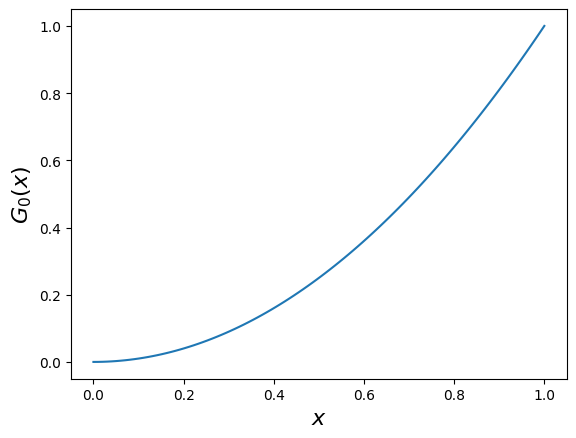

In [64]:
import numpy as np
import seaborn as sns

x = np.linspace(0, 1, 100)
y = pp.statistics.degree_generating_function(g.to_undirected(), x)
ax = sns.lineplot(x=x, y=y)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$G_0(x)$', fontsize=16);

In [65]:
k_2 = pp.statistics.degree_raw_moment(g.to_undirected(), k=2)
print(k_2)
k_1 = pp.statistics.degree_raw_moment(g.to_undirected(), k=1)
print(k_1)
print('Molloy-Reed Fraction <k^2>/<k>: ', k_2/k_1)

4.0
2.0
Molloy-Reed Fraction <k^2>/<k>:  2.0
